# Youtube comment's sentiment analysis

Authors: Stefano Perenzoni & Nicolás Arrieta Larraza

## Introduction

This notebook is part of the project named "Topic modelling and sentiment analysis of Youtube comments" and it contains our sentiment analysis approach on a british Youtube music videos comment's dataset. 

We mention more of the dataset in previous notebooks, thus, what it matters for this notebook is that the already-cleaned and filtered datase contains 51790 unlabebeled comments in english.

For such an unsupervised task, in the following sections we present:
* An implementation of our own sentiment analysis classifier that includes:
    * Data preprocessing
    
    * Word embedding (Word2Vec)
    
    * Clustering of words (K-Means)
    
    * Sentiment prediction based on TF-iDF and closeness scores of the words
    
    
* An analysis and comparison of more suitable models for this scenerario, which include: 

    * Sentiment analysis with Vader: A rule-based sentiment analysis tool tuned for social media content

    * Sentiment analysis with TextBlob: A rule-based sentiment analysis tool with Subjectivity analysis

    * Sentiment analysis with Flair: An embedding-based NLP framework with pre-trained sentiment analysis models
    
    
* A final approach with Ensemble Learning


## Importing libraries

In [1]:
import json
from time import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flair
from flair.models import TextClassifier
from flair.data import Sentence
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy 
from scipy.spatial import distance
import multiprocessing
from sklearn.cluster import KMeans
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
data_path = '../../data/'
models_path = '../../data/models/'

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/narrietal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing already filtered comments
We already filtered the coments from the initial raw dataset as follows:
* Keep only british comments
* Removing missing cells
* Removing duplicates

In [2]:
#Importing filtered comments
comments_df = pd.read_csv(data_path+'GB_comments_filtered.csv')

In [3]:
#Getting only the comments 
comments_text_df = comments_df['comment_text'].to_frame()
comments_text_df.head()

,comment_text
0,I didn't really like the song
1,alright... I'll take the stairs
2,a fable on a realistic ground is a cry of pro...
3,hope you will exist for many years..
4,Would this song exist if he lived on the first...


In [164]:
comments_text_df

,comment_text
0,I didn't really like the song
1,alright... I'll take the stairs
2,a fable on a realistic ground is a cry of pro...
3,hope you will exist for many years..
4,Would this song exist if he lived on the first...
...,...
51785,Whatever is related to him is = PURE PERFECTION
51786,"Zhu is awesome! Unfortunately, Adidas must of ..."
51787,Once again the Asians dominate!
51788,ZHU is a fucking magical aesthetic unicorn god


## Implementing our own sentiment analysis classifier

First, we attempt to implement our own classifier. We can foresee that it is a complex challenge as it is an unsupervised task on a dataset with a wide variety of comments.

Anyway, we believe it is interesting to develop this classic approach in order to compare it with the performance of more suitable models for this task.

In the following sections we proceed to do the tasks listed below:
* Preprocess the data: Clean, tokenize and lemmatize the comments
* Detect common phrases
* Create Word2Vec model
* Apply K-Means algorithm
* Estimate comment's sentiment analysis by computing the dot product of the tf-idf scores and sentiment analaysis scores of every word in the comment.


### Data preprocessing

Keeping only alphanumerical words, tokenizing, lemmatizing and erasing stop words

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def comment_to_word_list(comment):
    # Keeps only alpha numerical tokens
    comment = re.sub(r"[^A-Za-z']+", ' ', str(comment).lower())
    # Divides comment in tokens
    comment = word_tokenize(comment)
    # Lemmatizes and removes stopwords
    comment = [lemmatizer.lemmatize(token) for token in comment if not token in stop_words]
    
    return comment

In [5]:
t = time()

clean_comments_df = comments_text_df.copy()

clean_comments_df.comment_text = clean_comments_df.comment_text.apply(lambda x: comment_to_word_list(x))

print('Cleaning time: {} mins'.format(round((time() - t) / 60, 2)))

Cleaning time: 0.31 mins


### Bigram 

We use the Gensim Phrases to automatically detect common phrases from a given list of sentences. (E.g. "New York" would be returned as "New_York")

In [6]:
sent = [word for word in clean_comments_df.comment_text]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

### Word2Vec

We are going to embed the commets in 300 dimensional vectors with Word2Vec. We use the following parameters for the vectorization:

* min count = 3 - remove most unusual words from training embeddings (words that appear less than 3 times)
* window = 4 - Word2Vec model will learn to predict given word from up to 4 words to the left, and up to 4 words to the right
* vector_size = 300 - size of hidden layer used to predict surroundings of embedded word, which also stands for dimensions of trained embeddings
* sample = 1e-5 - probability baseline for subsampling most frequent words from surrounding of embedded word
* alpha = learning rate
* min_alpha = learning rate will decay to this value
* negative = 20 - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown.

In [9]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Time to build vocab: 0.02 mins


In [10]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.save(models_path+"word2vec.model")

Time to train the model: 0.68 mins


### K-Means

K-Means it is an iterative clustering algorithm, in which in first step K random data points are chosen as coordinates of clusters centroids (where n is the number of seeked clusters). In every step all points are assigned to their closest centroid, based on euclidean distance. Then, new coordinates of every centroid are calculated, as mean of coordinates of all data points assigned to each centroid, and iterations are repeated till reaching minimal value of squared sum of distances between points assigned to centroids, and their centroid coordinates (which just simply means that coordinates of clusters stop to change), or number of iterations reach given limit.

For our task, we choose K=50 clusters and a stoping criteria of 1000 iterations.

In [11]:
word_vectors = w2v_model.wv
start = time()
kmeans_model = KMeans(n_clusters=2, max_iter=1000, n_init=50)
kmeans_model.fit(X=word_vectors.vectors.astype('double'))

print('Time to compute K-Means algorithm: {} mins'.format(round((time() - start) / 60, 2)))


Time to compute K-Means algorithm: 0.12 mins


#### Discussing results

In order to understand which cluster belongs to positive or negative, we take a look at the words that are closest, in terms of cosine similarity, to the coordinates of the centroids of each cluster.

In [12]:
word_vectors.similar_by_vector(kmeans_model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('juss', 0.9997978806495667),
 ('freshly', 0.9997945427894592),
 ('chipmunk', 0.9997785687446594),
 ('racial', 0.9997736215591431),
 ('lotta', 0.9997729659080505),
 ('guccimane', 0.999771237373352),
 ('heared', 0.9997678399085999),
 ('wholesome', 0.9997676014900208),
 ('earthquake', 0.9997669458389282),
 ('tm', 0.9997663497924805)]

In [13]:
word_vectors.similar_by_vector(kmeans_model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('ntake', 0.9858958721160889),
 ('nhow', 0.9841887950897217),
 ('nwithout', 0.9833437204360962),
 ('nwill', 0.981657087802887),
 ('nare', 0.9787806868553162),
 ('nam', 0.9782816767692566),
 ('say', 0.976513683795929),
 ('mind', 0.9759274125099182),
 ('unsure', 0.9748870730400085),
 ('try', 0.9748343825340271)]

We can observe that the 2 closest words to the centroid of the first cluster are "goooood" and "wholesome". This could suggest that such a cluster could be the positive one.

However, based on the closest words, it is not clear if the second cluster belongs to negative reviews.

We can also check for certain words to see to which cluster they have been assigned to:

In [16]:
test_words = ['good', 'bad', 'wrong', "great", "terrible"]
for w in test_words:
    cluster_index = kmeans_model.labels_[word_vectors.key_to_index[w]]
    print('The word', w, 'was assigned to cluster:', cluster_index, 'at a distance from its centroid of:',distance.cosine(word_vectors[w], kmeans_model.cluster_centers_[cluster_index]),'\n')

The word good was assigned to cluster: 0 at a distance from its centroid of: 0.026116818818596843 

The word bad was assigned to cluster: 0 at a distance from its centroid of: 0.08549509233707464 

The word wrong was assigned to cluster: 1 at a distance from its centroid of: 0.09559552489929268 

The word great was assigned to cluster: 0 at a distance from its centroid of: 0.05570642855848751 

The word terrible was assigned to cluster: 0 at a distance from its centroid of: 0.012777189218619145 



As we can observe, the results seem to show that the clusters are not dividing correctly the words in terms of positive/negative sentiment. The words "good","bad","great" and "terrible" are assigned to the same, while "wrong" it is assigned differently.

We can guess that the final result will not be accurate, but we will continue with the task assuming that the first cluster belongs to positive words.

#### Assigning clusters

We will assign to each word a sentiment score, -1 or 1, depending on the cluster they belong to, negative or positive respectively. To get this score we multiply it by the distance to the centroid of their cluster. As the score that K-means algorithm outputs is distance from both clusters, to properly weigh them we multiplied them by the inverse of closeness score.

In [17]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: kmeans_model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [18]:
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(kmeans_model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value
words.head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,song,"[0.0847291, -0.046834808, -0.031612296, 0.0978...",0,1,0.950590,0.950590
1,love,"[0.18501046, 0.11311181, 0.0032570814, -0.0501...",1,-1,0.556316,-0.556316
2,'s,"[0.04604786, -0.050572217, -0.061958257, 0.062...",1,-1,0.656895,-0.656895
3,n,"[0.014859654, -0.17155193, -0.14537424, 0.1939...",1,-1,0.389754,-0.389754
4,like,"[0.09511839, 0.0051237526, -0.031544328, 0.093...",0,1,0.863353,0.863353


In [19]:
sentiment_dict_df = words[['words', 'sentiment_coeff']]
sentiment_dict = {row['words']:row['sentiment_coeff'] for index,row in sentiment_dict_df.iterrows()}

### Sentiment prediction

The last step is to predict the sentiment of every comment.

For that we first produce a vector with the tf-idf score of every word in a sentence. This gives more weight to the words that are more important in a sentence.

Then, we produce a second vector with the sentiment scores that we computed in the previous section for the same words in a sentence.

In order to get the final sentiment prediction score for that sentence, we compute the dot product of the vectors. If the dot product is positive, the sentiment is positive, otherwise is negative

In [20]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

tfidf.fit(clean_comments_df.comment_text)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(clean_comments_df.comment_text)

In [21]:
def create_tfidf_dictionary(x, transformed_file, features):
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.comment_text))


def replace_sentiment_words(word, sentiment_dict):
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

start = time()
replaced_tfidf_scores = clean_comments_df.apply(lambda x: replace_tfidf_words(x, transformed, features),axis=1)
replaced_closeness_scores = clean_comments_df.comment_text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x)))
print('Time to create tf-idf and closeness vectors: {} mins'.format(round((time() - start) / 60, 2)))

Time to create tf-idf and closeness vectors: 0.37 mins


In [22]:
sentiment_df = pd.DataFrame(data=[comments_text_df.comment_text, replaced_closeness_scores, replaced_tfidf_scores]).T
sentiment_df.columns = ['comment_text','sentiment_coeff', 'tfidf_scores']
sentiment_df['sentiment_rate'] = sentiment_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
sentiment_df['prediction'] = (sentiment_df.sentiment_rate>0).astype('int8')

In [25]:
sentiment_df.head()

,comment_text,sentiment_coeff,tfidf_scores,sentiment_rate,prediction
0,I didn't really like the song,"[-0.8887895303099768, 0.5568657165960161, 0.86...","[0.49077125350687817, 0.6206134296985032, 0.46...",0.687134,1
1,alright... I'll take the stairs,"[1.621816551909419, -0.37983587693121174, 0.53...","[0.5612342998154032, 0.39085294001535686, 0.38...",8.743038,1
2,a fable on a realistic ground is a cry of pro...,"[0, 9.191734999382218, -0.5380640659852599, -0...","[0.3803346994119293, 0.35037504803931013, 0.28...",11.256144,1
3,hope you will exist for many years..,"[0.9417209272109989, 5.508054667285054, 1.3563...","[0.43309359691929417, 0.6754506092727891, 0.43...",5.378246,1
4,Would this song exist if he lived on the first...,"[1.00602934646922, 0.950590108676847, 5.508054...","[0.30266359901576395, 0.176829989718542, 0.540...",5.489792,1


Text(0.5, 1.0, 'Histogram of prediction')

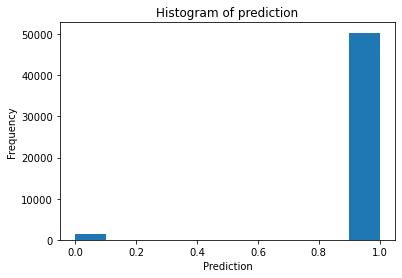

In [151]:
plt.hist(sentiment_df.prediction)
plt.xlabel("Prediction")
plt.ylabel("Frequency")
plt.title("Histogram of prediction")

In [27]:
sentiment_df['prediction'].value_counts()

1    50344
0     1446
Name: prediction, dtype: int64

### Discussion

We can observe that, as it was expected from the little promising results of the K-Means algorithm, the model does not classify correctly the comments.

The last histogram clearly shows that 97% of the instances belong to the "positive" cluster. This is undoubtly a wrong result since we know from the clustering section that negative words like "bad" or "terrible" were assigned a positive score.

Further development could be done to attempt achieving better results such as: Including 3rd "Neutral" cluster, computing K-means with cosine similarity, changing word2vector parameters, etc.

Given the results, seems like performing such a task through this approach might not be the best solution. Therefore, in the following sections, we will attempt the sentiment analysis tasks with three different approaches:

* Sentiment analysis with Vader: A rule-based sentiment analysis tool tuned for social media content

* Sentiment analysis with TextBlob: A rule-based sentiment analysis tool with Subjectivity analysis

* Sentiment analysis with Flair: An embedding-based NLP framework with pre-trained sentiment analysis models

## Sentiment Analysis with Vader

Vader (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

The scores provided by Vader are the following:

* Neg, Neu and Pos are a proportional score oh how many negative, neutral or positive words are found in a sentence. They should sum up to 1.

* Compound is the score computed by summing the scores of each word in the lexicon and normalized. Thus, the value is bounded between -1 (most negative) and 1 (most positive).
    * If compound score <=  -0.05 NEGATIVE
    * If compound score > -0.05 and <0.05 NEUTRAL
    * If compound score >=  0.05 POSITIVE

In [28]:
vader_analyser = SentimentIntensityAnalyzer()

In [29]:
vader_analyser.polarity_scores("aaaaa")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [30]:
vader_scores = []
for row in comments_text_df.comment_text:
    score = vader_analyser.polarity_scores(row)
    vader_scores.append(score)

#Converting List of Dictionaries into Dataframe
vader_scores_df= pd.DataFrame(vader_scores)

In [31]:
vader_rated_comments_df = pd.concat([comments_text_df, vader_scores_df], axis=1)
vader_rated_comments_df['Prediction'] = [1 if i>0.05 else -1 if i<0.05 else 0 for i in vader_rated_comments_df.compound]
vader_rated_comments_df.head()

,comment_text,neg,neu,pos,compound,prediction
0,I didn't really like the song,0.318,0.682,0.000,-0.3241,-1
1,alright... I'll take the stairs,0.000,0.667,0.333,0.2500,1
2,a fable on a realistic ground is a cry of pro...,0.223,0.699,0.079,-0.5106,-1
3,hope you will exist for many years..,0.000,0.674,0.326,0.4404,1
4,Would this song exist if he lived on the first...,0.000,1.000,0.000,0.0000,0


## Sentiment Analysis with TextBlob

TextBlov is another rule-based sentiment analysis tool in which sentiments are defined based on semantic relations and the frequency of each word in an input sentence.

The scores provided by TextBob are the following:

* Polarity score: float within the range [-1.0, 1.0] where -1.0 is a negative polarity and 1.0 is positive. This score can also be equal to 0, which stands for a neutral evaluation

* Subjectivity score: loat within the range [0.0, 1.0] where 0.0 is a very objective sentence and 1.0 is very subjective.

In [33]:
textblob_scores = []
for row in comments_text_df.comment_text:
    score = {}
    score['Polarity'] = TextBlob(row).sentiment.polarity
    score['Subjectivity'] = TextBlob(row).sentiment.subjectivity
    textblob_scores.append(score)

#Converting List of Dictionaries into Dataframe
text_blob_scores_df= pd.DataFrame(textblob_scores)

In [34]:
textblob_rated_comments_df = pd.concat([comments_text_df, text_blob_scores_df], axis=1)
textblob_rated_comments_df['Prediction'] = [1 if i>0 else -1 if i<0 else 0 for i in textblob_rated_comments_df.Polarity]
textblob_rated_comments_df.head()

,comment_text,Polarity,Subjectivity,prediction
0,I didn't really like the song,0.200000,0.200000,1
1,alright... I'll take the stairs,0.000000,0.000000,0
2,a fable on a realistic ground is a cry of pro...,0.166667,0.333333,1
3,hope you will exist for many years..,0.500000,0.500000,1
4,Would this song exist if he lived on the first...,0.250000,0.333333,1


## Sentiment Analysis with Flair

Flair is an state-of-the-art NLP framework that provides, among other things, a sentiment analysis tool. Flair’s sentiment classifier is based on a character-level LSTM neural network which takes sequences of letters and words into account when predicting.

The score provided by Flair is a confidence value within the range [0, 1] for Positive and Negative analysis. We decided to turn the the Negative analysis confidence number into a negative value within the range [-1, 0]. Therefore, the final prediction scores are computed as following:
* If confidence score <0 NEGATIVE
* If confidence score >0 POSITIVE

In [58]:
flair_classifier = TextClassifier.load('en-sentiment')
def predict(comment):
    text = Sentence(comment)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['labels'][0]['confidence']
    else:
        result = -(text.to_dict()['labels'][0]['confidence'])
    return round(result, 3)

In [65]:
t = time()
flair_scores = []
for row in comments_text_df.comment_text:
    sent = predict(row)
    score = {}
    score['Sentiment'] = sent
    flair_scores.append(score)

#Converting List of Dictionaries into Dataframe
flair_scores_df= pd.DataFrame(flair_scores)
print('Time to classify all comments : {} mins'.format(round((time() - t) / 60, 2)))

Time to classify all comments : 58.01 mins


In [88]:
flair_rated_comments_df = pd.concat([comments_text_df, flair_scores_df], axis=1)
flair_rated_comments_df['Prediction'] = [1 if i>0 else -1 for i in flair_rated_comments_df.Sentiment]
flair_rated_comments_df.head()

,comment_text,Sentiment,Prediction
0,I didn't really like the song,-1.000,-1
1,alright... I'll take the stairs,-0.841,-1
2,a fable on a realistic ground is a cry of pro...,-0.895,-1
3,hope you will exist for many years..,0.997,1
4,Would this song exist if he lived on the first...,0.875,1


In [90]:
#Saving dataframes
vader_rated_comments_df.to_csv(data_path+'vader_rated_comments.csv', index = False)
textblob_rated_comments_df.to_csv(data_path+'textblob_rated_comments.csv', index = False)
flair_rated_comments_df.to_csv(data_path+'flair_rated_comments.csv', index = False)

### Discussion of results

In this section we discuss the predictions of each model based on certain chosen samples.

In [106]:
rates_combined = vader_rated_comments_df['comment_text'].to_frame().copy()
rates_combined['vader_sentiment'] = vader_rated_comments_df['compound'].copy()
rates_combined['textblob_sentiment'] = textblob_rated_comments_df['Polarity'].copy()
rates_combined['flair_sentiment'] = flair_rated_comments_df['Sentiment'].copy()

#### Positve comments
For the first positive comment shown below, the three models were able to predict the sentiment correctly. We can observe that Vader and Flair's predictions are much better than Textblob's. This is probably because Vader and Flair models are able to indetify intesinfiers ("SO MUCH") and also understand emojis in contexts.

The second positive comment is trickier since it contains words that are probably Out Of the Vocabulary (OOV) for the vader and textblob models. However we can observe that Flair works acccurately for this kind of cases of OOV words.

In [142]:
rates_combined.loc[45484,:].to_dict()

{'comment_text': 'LOVE THIS SO MUCH ❤️😍',
 'vader_sentiment': 0.8374,
 'textblob_sentiment': 0.35,
 'flair_sentiment': 0.989}

In [138]:
rates_combined.loc[9372,:].to_dict()

{'comment_text': 'Oh My Gawd! ♡♡♡ This is so aesthetic and BOBBYYYYY NADEO SARANGHAE!',
 'vader_sentiment': 0.0,
 'textblob_sentiment': 0.0,
 'flair_sentiment': 0.791}

#### Negative comments
The results in the examples below are quite surprising. The Flair model was accurate about the negativity of the comments, however the vader and textblob models did not perform well. 

In the case of the vader model, it predicts the first comment as positive and the second as negative. 

In the case of the textblob model, it is not able to detect the negative comment in any situation and predicts a neutral comment.

In [146]:
rates_combined.loc[45878,:].to_dict()

{'comment_text': 'I don’t like his glasses and hair',
 'vader_sentiment': 0.3612,
 'textblob_sentiment': 0.0,
 'flair_sentiment': -1.0}

In [133]:
rates_combined.loc[23039,:].to_dict()

{'comment_text': "I don't like this one Tamar",
 'vader_sentiment': -0.2755,
 'textblob_sentiment': 0.0,
 'flair_sentiment': -1.0}

#### Mixed-sentiment comments

In the dataset there are also some comments with mixed feelings as we can see below. 

In this sorts of cases, we can observe that the Textblob and Vader models perform better than Flair's. Both comments are hard to indentify as they could be seen as neutral or slightly positive/negative. Vader model tend to predict them as sligthly negative, while Textblob predict them as neutral or slightly positive.

Flair model performs poorly in both cases predicting a high negative score.

In [131]:
rates_combined.loc[46227,:].to_dict()

{'comment_text': "I like the song but I don't like the vocals at the beginning",
 'vader_sentiment': -0.2299,
 'textblob_sentiment': 0.0,
 'flair_sentiment': -0.998}

In [147]:
rates_combined.loc[9720,:].to_dict()

{'comment_text': "This is a good song and all, but for me it doesn't have that special feeling.",
 'vader_sentiment': -0.0482,
 'textblob_sentiment': 0.5285714285714286,
 'flair_sentiment': -0.873}

#### Missleading comments

We call the comments below "missleading" since they have a clear positive feeling, but contain expressions that might misslead the prediction of the models.

The first comment, is well predicted by the Flair model, but the rest of the models perform poorly. It is worth highlighting that the Vader model predicts quite negative score and it mght be due to the swearing word at the start of the comment.

The second comment shows interesting results as it is properly detected by the rule-based models. However, the Flair model is unable to detect the positivism on the comment and performs a poor prediction providing a high negative score.

In [134]:
rates_combined.loc[116,:].to_dict()

{'comment_text': 'Damn, I miss this Radiohead',
 'vader_sentiment': -0.5106,
 'textblob_sentiment': 0.0,
 'flair_sentiment': 0.999}

In [135]:
rates_combined.loc[22408,:].to_dict()

{'comment_text': 'Not bad not bad at all🤔',
 'vader_sentiment': 0.1232,
 'textblob_sentiment': 0.3499999999999999,
 'flair_sentiment': -0.959}

### Conclusions

After studying the sentiment analysis results of the three models in a few comments, we can draw the following conclusions:

* **Emoji comprehension**: Both Vader and Flair models seem to handle them correctly, however TextBlob is unable to process them.

* **Out Of the Vocabulary words**: Only the Flair model is able to capture the sentiment of sentences with OOV words.

* **Intensifiers**: Both Vader and Flair models seem to handle them correctly, however TextBlob is unable to take them into account.

* **Clear Positive comments**: Correctly predicted by all the models

* **Clear Negative comments**: Only the Flair model is able to correctly predict them
* **Mixed-sentiment comments**: Vader and Textblob seem to handle them correctly, however Flair model seem to perform badly.

* **Missleading comments**: Neither of the models is able to analyse correctly the sentiment of such comments in all the cases

Based on these conclusions, we think that a combination of the three model predictions could be a good approach to compute a final sentiment score on the comments. For that reason, in the next section we compute an ensemble technique of the three models, in which we will calculate the sentiment score through a weighted average of the previous results.

### Ensemble technique

As we mention in the conclusions, we are going to implement an ensemble technique to obtain the final sentiment scores on the comments. This technique produces an output that is the weighted average of the three models. The weights are assigned as follows:

* The Flair model seems to give (generally) better predictions, so we assign it a weight of 50%.
* The Vader model seems to perform better than TextBlob, so we assign it a weight of 30%
* Finally the TextBlob is assigned with a weight of 20%


In [153]:
ensemble_sentiment = []
for index, row in rates_combined.iterrows():
    score = (row['flair_sentiment']*0.5 + row['vader_sentiment']*0.3+ row['textblob_sentiment']*0.2)/3
    ensemble_sentiment.append(score)
    
ensemble_rates_df = rates_combined['comment_text'].to_frame().copy()
ensemble_rates_df['ensemble_sentiment'] = ensemble_sentiment
ensemble_rates_df['prediction'] = [1 if i>0 else -1 for i in ensemble_rates_df.ensemble_sentiment]

In [163]:
ensemble_rates_df.head()

,comment_text,ensemble_sentiment,prediction
0,I didn't really like the song,-0.185743,-1
1,alright... I'll take the stairs,-0.115167,-1
2,a fable on a realistic ground is a cry of pro...,-0.189116,-1
3,hope you will exist for many years..,0.243540,1
4,Would this song exist if he lived on the first...,0.162500,1


### Final thoughts

After applying the ensemble technique and overviewing the results, a high improvement can be observed.

All the simple comments are predicted correctly and this time taking account the negative too. The trickier cases such as mixed-sentiment or missleading comments are not fixed completely, in some cases the final prediction is still wrong but the "confidence" on such a result lowers.